In [1]:
import os
def homePath(path):
    return os.path.join(os.path.expanduser("~"), path.strip("~/"))

#Model Creation 1
#Figure out how to do versioning effectively
individualInput = False
combinedInputPath = homePath("~/SPGenerations/")
pathToTokenizedData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Tokenizer\\"
pathToGradeData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Grader\\"
GradesTokensName = ""


if not individualInput:
    pathToTokenizedData = os.path.join(combinedInputPath, "Tokens/")
    pathToGradeData = os.path.join(combinedInputPath, "Grades/")

if GradesTokensName == "":
    #Use newest folder for each

    #Get the newest folder for the tokens
    tokensFolders = os.listdir(pathToTokenizedData)
    tokensFolders.sort()
    pathToTokenizedData = os.path.join(pathToTokenizedData , tokensFolders[-1])

    #Get the newest folder for the grades
    gradesFolders = os.listdir(pathToGradeData)
    gradesFolders.sort()
    pathToGradeData = os.path.join(pathToGradeData,  gradesFolders[-1])
else:
    pathToTokenizedData = os.path.join(pathToTokenizedData, GradesTokensName)
    pathToGradeData = os.path.join(pathToGradeData, GradesTokensName)





modelOutputPath = homePath("~/SPGenerations/Models")



In [2]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.layers as layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model




from keras.utils import pad_sequences
import os



#Load the data
#tokenized data is in tokenizedData.pkl, has tokenizer obj in tokenizer.json

#Load the tokenizer
with open(pathToTokenizedData+ "/tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())



#Load the tokenized data
with open(pathToTokenizedData + "/tokenizedData.pkl", "rb") as f:
    tokenizedData = pickle.load(f)

#Load the grade data
#gradeData is a dict with keys as the file names and values as the grades
with open(pathToGradeData + "/grades.pkl", "rb") as f:
    gradeData = pickle.load(f)

combinedDF = pd.merge(tokenizedData, gradeData, on = "Path")
print (combinedDF)







2023-10-28 00:10:26.683917: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-28 00:10:26.718334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 00:10:26.718356: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 00:10:26.718383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 00:10:26.725432: I tensorflow/core/platform/cpu_feature_g

                                                tokenCode  \
0       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
1       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
2       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
3       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
4       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
...                                                   ...   
221097  [26, 708, 41, 278, 26, 278, 26, 869, 26, 270, ...   
221098  [41, 278, 26, 278, 26, 869, 26, 270, 41, 1326,...   
221099  [26, 708, 41, 278, 26, 278, 26, 869, 26, 270, ...   
221100  [41, 278, 26, 278, 26, 869, 26, 270, 41, 1326,...   
221101  [26, 708, 41, 278, 26, 278, 26, 869, 26, 270, ...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/3.py  67.000000  
2       3722273/examples/basics/linear_regression.py/2

In [3]:
#Padding

maxLen = 500
#get rid of the ones that are too long
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

print (combinedDF)




                                                tokenCode  \
0       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
1       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
2       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
3       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
4       [8, 41, 426, 26, 609, 4, 754, 4, 649, 26, 2348...   
...                                                   ...   
221088  [41, 426, 26, 859, 2, 19, 7, 8, 2, 22, 7, 8, 2...   
221089  [41, 426, 26, 859, 26, 81, 2, 19, 7, 8, 2, 22,...   
221090  [41, 426, 26, 859, 2, 19, 7, 8, 2, 22, 7, 8, 2...   
221091  [41, 426, 26, 859, 26, 270, 26, 81, 2, 19, 7, ...   
221092  [41, 426, 26, 859, 26, 270, 26, 81, 2, 19, 7, ...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/3.py  67.000000  
2       3722273/examples/basics/linear_regression.py/2

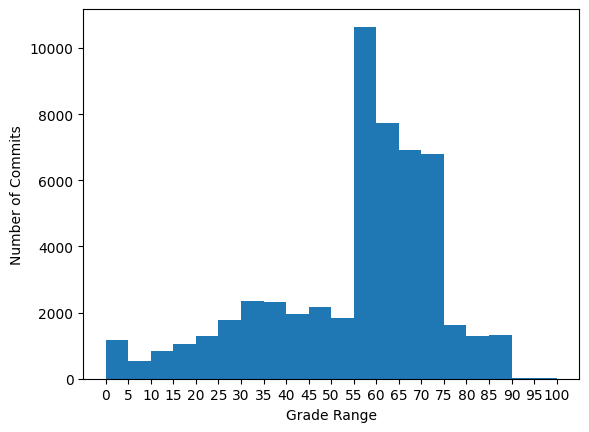

In [4]:
#create a chart of the grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()



In [5]:
#test to make sure gpu is detected and save as bool
gpu_detected = tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-10-28 00:11:02.585025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2023-10-28 00:11:02.585950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6


ba5f723144744db29f788391b0b1b7a24bb8214f



2023-10-28 00:11:10.386452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2023-10-28 00:11:10.387174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6
2023-10-28 00:11:14.485259: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 1024)         10240000  
                                                                 
 conv1d (Conv1D)             (None, 498, 2048)         6293504   
                                                                 
 global_max_pooling1d (Glob  (None, 2048)              0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 2048)           25174016  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 2048)           0

2023-10-28 01:05:10.184753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-28 01:05:10.805117: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-28 01:05:13.707182: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc7adcaeb20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-28 01:05:13.707203: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2023-10-28 01:05:13.707207: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A2, Compute Capability 8.6
2023-10-28 01:05:13.711200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-28 01:05:13.817837: I ./tensorflow/compiler/jit/device_compiler.h:186] Co

1678/1678 [==============================] - 270s 153ms/step - loss: 0.3066 - mse: 293.9807 - mae: 13.3527 - mape: 280152192.0000 - accuracy: 4.2841e-04
Epoch 2/100
1678/1678 [==============================] - 252s 150ms/step - loss: 0.1485 - mse: 146.9614 - mae: 9.0757 - mape: 110642592.0000 - accuracy: 3.7253e-05
Epoch 3/100
1678/1678 [==============================] - 252s 150ms/step - loss: 0.1336 - mse: 129.1710 - mae: 8.4672 - mape: 93396760.0000 - accuracy: 1.8626e-05
Epoch 4/100
1678/1678 [==============================] - 252s 150ms/step - loss: 0.1240 - mse: 120.8943 - mae: 8.1852 - mape: 90502936.0000 - accuracy: 1.8626e-04
Epoch 5/100
1678/1678 [==============================] - 252s 150ms/step - loss: 0.1176 - mse: 114.5202 - mae: 7.9655 - mape: 86055312.0000 - accuracy: 1.8626e-05
Epoch 6/100
1678/1678 [==============================] - 252s 150ms/step - loss: 0.1095 - mse: 107.3026 - mae: 7.7025 - mape: 77050120.0000 - accuracy: 9.3132e-05
Epoch 7/100
1678/1678 [========

KeyError: 'val_loss'

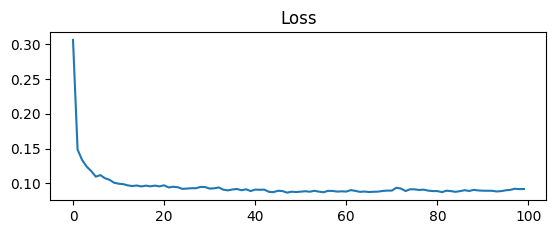

In [6]:
#if (not gpu_detected):
#    print("GPU not detected, using CPU")

model = Sequential()
model.add(Embedding(tokenizer.num_words, 1024, input_length=maxLen))
model.add(layers.Conv1D(2048, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Reshape((1, 2048)))
model.add(layers.Bidirectional(LSTM(1024, return_sequences=True)))
model.add(Dropout(0.38479930887149405))
model.add(layers.Bidirectional(LSTM(512)))
model.add(layers.Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1, activation='linear'))

print(model.summary())

model.compile(loss='mean_squared_logarithmic_error', optimizer='Adam', metrics=['mse', 'mae', 'mape', 'accuracy'])

hist = model.fit(combinedDF["tokenCode"].tolist(), combinedDF["fileGrade"].tolist(), epochs=100, batch_size=32,verbose = 1)



#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now())
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#make an archaive of the SCA-Tokenizer Folder
#get CWD
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)


plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [7]:
#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now())
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#make an archaive of the SCA-Tokenizer Folder
#get CWD
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)

/home/mcall/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/TokenizerManager.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/CaMlSupportingClasses.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/PythonProcessing.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CaMlSupportingClasses.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CodeSimilarization.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/PythonProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/TokenProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/TokenProcessing.py
/home/mcall/SP

tar: 15\:06\:35.098494/SCA-Tokenizer.tar.gz: Cannot stat: No such file or directory
tar: Removing leading `/' from member names
tar: Removing leading `/' from hard link targets
tar: Exiting with failure status due to previous errors
tar: 15\:06\:35.098494/Auto-Grader.tar.gz: Cannot stat: No such file or directory
tar: Removing leading `/home/mcall/SPGit/Model-Generation/../' from member names
tar: Removing leading `/home/mcall/SPGit/Model-Generation/../' from hard link targets
tar: Exiting with failure status due to previous errors


In [8]:
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)

/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/TokenizerManager.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/CaMlSupportingClasses.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/PythonProcessing.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CaMlSupportingClasses.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CodeSimilarization.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/PythonProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/TokenProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/TokenProcessing.py
/home/mcall/SP

tar: Removing leading `/' from member names
tar: Removing leading `/home/mcall/SPGit/Model-Generation/../' from member names
